In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import h5py
import re
import random

In [4]:
swf360_dir = "/store1/shared/sparseGFP_SWF360/data_processed_220"
swf467_dir = "/store1/shared/panneuralGFP_SWF467/data_processed_220"
# swf1212_dir = "/store1/shared/panneuralGFP_SWF1212/data_processed_220"
prj_ssn_dir = "/data1/prj_sexsharedneurons/FailedHeadReg"
demo_cam_dir = "/store1/shared/confocal_debugging/data_processed_220"
new_cam_prj_starv_dir = "/store1/candy/prj_starvation/data_processed"

### ImageClick main version

In [5]:
labels_dir = {
    # swf360
    "2022-03-16-03": swf360_dir + "/2022-03-16-03_output/ImageClick/coordinates_20241227_230032.csv",
    "2022-03-24-02": swf360_dir + "/2022-03-24-02_output/ImageClick/coordinates_20241227_222855.csv",
    "2022-03-30-01": swf360_dir + "/2022-03-30-01_output/ImageClick/coordinates_20250111_025054.csv",
    "2022-03-30-02": swf360_dir + "/2022-03-30-02_output/ImageClick/coordinates_20250114_005049.csv",
    "2022-03-31-01": swf360_dir + "/2022-03-31-01_output/ImageClick/coordinates_20250114_001624.csv",
    
    # swf467    
    "2022-03-16-02": swf467_dir + "/2022-03-16-02_output/ImageClick/coordinates_20250105_204910.csv",

    # swf1212
    "2024-05-22-08": "/data1/prj_sexsharedneurons/FailedHeadReg/2024-05-22-08/labels.csv",

    # demo cam swf702
    "2024-12-19-07": demo_cam_dir + "/2024-12-19-07_output/ImageClick/....csv",

    # demo cam swf1212
    "2024-12-19-08": demo_cam_dir + "/2024-12-19-08_output/ImageClick/coordinates_20250107_000302.csv",
    "2024-12-19-10": demo_cam_dir + "/2024-12-19-10_output/ImageClick/....csv",

    # new cam swf702
    "2025-02-03-04": new_cam_prj_starv_dir + "/2025-02-03-04_output/ImageClick/coordinates_20250207_160014.csv",

    # new cam swf1212
}

In [6]:
# ### if you only want to include positive examples where the head is clearly visible
# max_per_dataset = 60
# all_imgs_raw = []
# all_imgs_label = []

# for k,path_csv in labels_dir.items():
#     print(path_csv)
    
#     png_dir = os.path.dirname(path_csv)
#     csv = pd.read_csv(path_csv)

#     for row in range(min(len(csv), max_per_dataset)):
        
#         png_path = os.path.join(png_dir, csv['Image'][row]) # create full path
#         img_raw = np.array(Image.open(png_path), dtype=np.uint16)
        
#         # head_pos = (csv['Y'][row], csv['X'][row]) # invert xy coordinates to retrieve label as a single point
#         img_label = np.zeros(img_raw.shape, dtype=bool)

#         # Create meshgrid of coordinates
#         y, x = np.ogrid[:img_label.shape[0], :img_label.shape[1]]
        
#         # Calculate distances from head_pos
#         distances = np.sqrt((x - csv['X'][row])**2 + (y - csv['Y'][row])**2)
        
#         # Set values where distance < 25 to 1
#         img_label[distances < 25] = 1

#         all_imgs_raw.append(img_raw)
#         all_imgs_label.append(img_label)

/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-16-03_output/ImageClick/coordinates_20241227_230032.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-24-02_output/ImageClick/coordinates_20241227_222855.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-30-01_output/ImageClick/coordinates_20250111_025054.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-30-02_output/ImageClick/coordinates_20250114_005049.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-31-01_output/ImageClick/coordinates_20250114_001624.csv
/store1/shared/panneuralGFP_SWF467/data_processed_220/2022-03-16-02_output/ImageClick/coordinates_20250105_204910.csv
/data1/prj_sexsharedneurons/FailedHeadReg/2024-05-22-08/labels.csv
/store1/shared/confocal_debugging/data_processed_220/2024-12-19-08_output/ImageClick/coordinates_20250107_000302.csv


In [33]:
### if you would like to include both positive and negative examples
max_positives = 50 # per dataset
max_negatives = 20 # per dataset

all_imgs_raw = []
all_imgs_label = []

# This will hold info about each negative example we add:
# e.g. [(index_in_all_imgs_label, dataset_id, csv_path, frame_filename), ...]
negative_info = []

# Suppose 'labels_dir' is a dict with {some_id: path_to_csv}
for dataset_id, path_csv in labels_dir.items():
    print(f"Processing CSV: {path_csv}")
    df = pd.read_csv(path_csv)
    png_dir = os.path.dirname(path_csv)
    
    #--------------------------------------------------------------------------
    # Helper function to extract frame number from filename, e.g. "frame_12.png" -> 12
    #--------------------------------------------------------------------------
    def extract_frame_num(fname):
        match = re.search(r"(\d+)", fname)
        return int(match.group(1)) if match else None
    
    #--------------------------------------------------------------------------
    # 1) Identify positive rows (exclude "skipped")
    #--------------------------------------------------------------------------
    positive_df = df[df["Image"] != "skipped"].copy()
    
    #--------------------------------------------------------------------------
    # 2) Gather all .png files in the folder and map them to frame numbers
    #--------------------------------------------------------------------------
    all_pngs = sorted([f for f in os.listdir(png_dir) if f.lower().endswith(".png")])
    frame_map = {}
    for fn in all_pngs:
        fnum = extract_frame_num(fn)
        if fnum is not None:
            frame_map[fnum] = fn
    
    # Determine the max frame from CSV or filenames
    if "Frame" in df.columns:
        max_frame_num_csv = int(df["Frame"].max())
    else:
        max_frame_num_csv = max(frame_map.keys()) if frame_map else 0
    
    #--------------------------------------------------------------------------
    # 3) Figure out which frames are used by positives and which are "skipped"
    #--------------------------------------------------------------------------
    used_frame_nums = set()
    for idx, row in positive_df.iterrows():
        fnum = extract_frame_num(row["Image"])
        if fnum is not None:
            used_frame_nums.add(fnum)
    
    skipped_df = df[df["Image"] == "skipped"].copy()
    
    # If there's a "Frame" column, read skipped frames directly:
    skipped_frame_nums = set()
    if "Frame" in skipped_df.columns:
        skipped_frame_nums = set(skipped_df["Frame"].unique())
    
    #--------------------------------------------------------------------------
    # 4) Build negative candidates
    #    - Frames listed as "skipped" (that exist on disk)
    #    - Frames within [1..max_frame_num_csv] not used by positives,
    #      not skipped, but exist as PNG
    #--------------------------------------------------------------------------
    negative_candidates = []
    
    # from "skipped" rows
    for fnum in skipped_frame_nums:
        if fnum in frame_map:
            negative_candidates.append(frame_map[fnum])
    
    # from frames not in used_frame_nums or skipped_frame_nums
    for fnum in range(1, max_frame_num_csv + 1):
        if (fnum not in used_frame_nums) and (fnum not in skipped_frame_nums):
            if fnum in frame_map:
                negative_candidates.append(frame_map[fnum])
    
    # Shuffle and take up to max_negatives
    random.shuffle(negative_candidates)
    negative_candidates = negative_candidates[:max_negatives]
    
    #--------------------------------------------------------------------------
    # 5) Load negative images (label array = zero)
    #--------------------------------------------------------------------------
    for neg_fname in negative_candidates:
        neg_path = os.path.join(png_dir, neg_fname)
        
        img_raw = np.array(Image.open(neg_path), dtype=np.uint16)
        img_label = np.zeros(img_raw.shape, dtype=bool)
        
        # Record the next index that this image will occupy:
        neg_index = len(all_imgs_label)  # or len(all_imgs_raw), both are in sync
        
        # Append the data
        all_imgs_raw.append(img_raw)
        all_imgs_label.append(img_label)
        
        # Store info for printing later
        negative_info.append(
            (neg_index, dataset_id, path_csv, neg_fname)
        )
    
    #--------------------------------------------------------------------------
    # 6) Load positive images (label array = circle near X,Y)
    #--------------------------------------------------------------------------
    positive_df = positive_df.head(max_positives)
    for idx, row in positive_df.iterrows():
        png_path = os.path.join(png_dir, row["Image"])
        img_raw = np.array(Image.open(png_path), dtype=np.uint16)
        img_label = np.zeros(img_raw.shape, dtype=bool)
        
        # Mark a circular region near (X, Y)
        y_grid, x_grid = np.ogrid[: img_label.shape[0], : img_label.shape[1]]
        dist = np.sqrt((x_grid - row["X"])**2 + (y_grid - row["Y"])**2)
        img_label[dist < 25] = True
        
        all_imgs_raw.append(img_raw)
        all_imgs_label.append(img_label)

#------------------------------------------------------------------------------
# Done processing all CSVs — now print out negative info
#------------------------------------------------------------------------------
print("\n---- Summary of Negative Examples ----")
for neg_idx, ds_id, csv_path, neg_fname in negative_info:
    print(f"Index in all_imgs_label: {neg_idx}, "
          f"Dataset ID: {ds_id}, "
          # f"CSV path: {csv_path}, "
          f"Frame filename: {neg_fname}")

print(f"\nTotal images collected: {len(all_imgs_label)}")
print(f"\nPositive examples: {len(all_imgs_label) - len(negative_info)}")
print(f"\nNegative examples: {len(negative_info)}")

Processing CSV: /store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-16-03_output/ImageClick/coordinates_20241227_230032.csv
Processing CSV: /store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-24-02_output/ImageClick/coordinates_20241227_222855.csv
Processing CSV: /store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-30-01_output/ImageClick/coordinates_20250111_025054.csv
Processing CSV: /store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-30-02_output/ImageClick/coordinates_20250114_005049.csv
Processing CSV: /store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-31-01_output/ImageClick/coordinates_20250114_001624.csv
Processing CSV: /store1/shared/panneuralGFP_SWF467/data_processed_220/2022-03-16-02_output/ImageClick/coordinates_20250105_204910.csv
Processing CSV: /data1/prj_sexsharedneurons/FailedHeadReg/2024-05-22-08/labels.csv
Processing CSV: /store1/shared/confocal_debugging/data_processed_220/2024-12-19-08_output/ImageClick/coordinates_20250107_000302

Text(0.5, 1.0, 'Overlay')

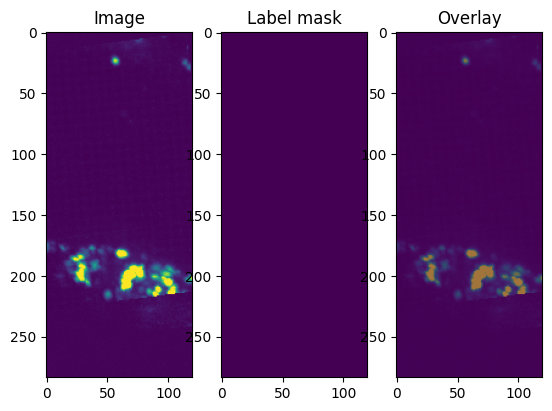

In [35]:
### visualize examples
i = 50
plt.subplot(1,3,1)
plt.imshow(all_imgs_raw[i])
plt.title("Image")
plt.subplot(1,3,2)
plt.imshow(all_imgs_label[i])
plt.title("Label mask")
plt.subplot(1,3,3)
plt.imshow(all_imgs_raw[i])
plt.imshow(all_imgs_label[i], alpha=0.5)
plt.title("Overlay")

### Gradio ImageClick

In [5]:
another_labels_dir = {
    
}

In [6]:
max_per_dataset = 60

for k,path_csv in another_labels_dir.items():
    print(path_csv)
    
    png_dir = os.path.dirname(path_csv)
    csv = pd.read_csv(path_csv)

    for row in range(min(len(csv), max_per_dataset)):
        
        png_path = os.path.join(png_dir, csv['image_name'][row]) # create full path
        img_raw = np.array(Image.open(png_path), dtype=np.uint16)
        
        # head_pos = (csv['Y'][row], csv['X'][row]) # invert xy coordinates to retrieve label as a single point
        img_label = np.zeros(img_raw.shape, dtype=bool)

        # Create meshgrid of coordinates
        y, x = np.ogrid[:img_label.shape[0], :img_label.shape[1]]
        
        # Calculate distances from head_pos
        str_coords = csv['coordinates'][row]
        if str_coords != "skipped":
            coords = str_coords.split(',')  
            xcoord = int(coords[0])           
            ycoord = int(coords[1])        
            distances = np.sqrt((x - xcoord)**2 + (y - ycoord)**2)
            
            # Set values where distance < 25 to 1
            img_label[distances < 25] = 1
    
            all_imgs_raw.append(img_raw)
            all_imgs_label.append(img_label)

### Export data as HDF5

In [7]:
path_new_h5 = "/store1/candy/prj_unet2d/data/postCropNet_2024.h5"
total = 0

# Open the HDF5 file in write mode
with h5py.File(path_new_h5, 'w') as f:
    for i in range(len(all_imgs_label)):  # Python uses 0-based indexing
        # Create group name as string
        d = str(i + 1)  # +1 to match Julia's 1-based indexing
        
        # Create a new group
        grp = f.create_group(d)
        
        # Store the image and label data in the group
        # Convert to uint16 (equivalent to UInt16 in Julia)
        grp.create_dataset("img", data=all_imgs_raw[i].astype(np.uint16))
        grp.create_dataset("label", data=all_imgs_label[i])
        total += 1
total

480

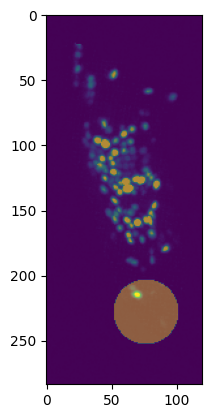

In [12]:
### check to see if output is as expected
path_h5 = "/store1/candy/prj_unet2d/data/postCropNet_2024.h5"
i = '250'

with h5py.File(path_h5, 'r') as file:
    img_raw = file[i]['img'][()]    # converts to numpy array
    img_label = file[i]['label'][()] # converts to numpy array

plt.imshow(img_raw)
plt.imshow(img_label, alpha=0.4)